In [1]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
from skimage import data, color, transform, feature
faces = fetch_lfw_people()
positive_patches = faces.images
print(positive_patches.shape)

(13233, 62, 47)


In [4]:
from skimage import data, transform, color
imgs_to_use = ['camera', 'text', 'coins', 'moon',
                      'page', 'clock', 'immunohistochemistry',
                      'chelsea', 'coffee', 'hubble_deep_field']
images = []
for name in imgs_to_use:
    img = getattr(data, name)()
    if img.ndim == 3 and img.shape[-1] == 3:
        images.append(color.rgb2gray(img))
    else:
        images.append(img)

In [5]:
from sklearn.feature_extraction.image import PatchExtractor
def extract_patches(img, N, scale=1.0,
                    patch_size=positive_patches[0].shape):
    extracted_patch_size = \
        tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches
negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
print(negative_patches.shape)

(30000, 62, 47)


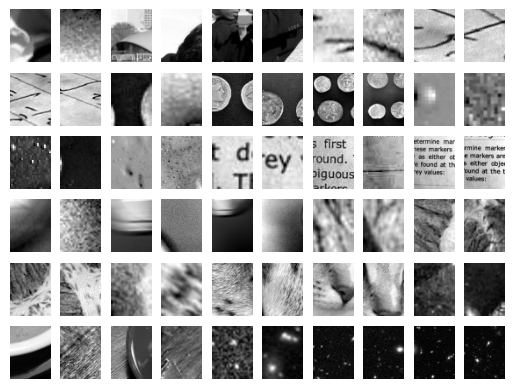

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')
plt.show()

In [7]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1
print(X_train.shape)

(43233, 1215)


In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), X_train, y_train)

array([0.95663236, 0.972476  , 0.97363247, 0.97640527, 0.97536433])

In [9]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

np.float64(0.9887816989072598)

In [10]:
grid.best_params_

{'C': 2.0}

In [11]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=2.0)

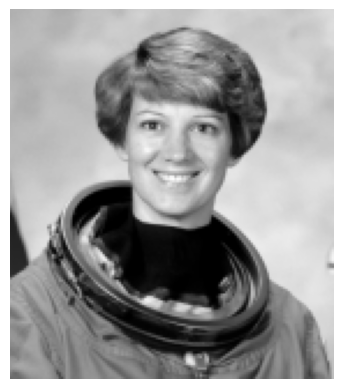

In [12]:
import skimage
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]
plt.imshow(test_image, cmap='gray')
plt.axis('off')
plt.show()

In [13]:
def sliding_window(img,
                   patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
      for j in range(0, img.shape[1] - Ni, jstep):
        patch = img[i:i + Ni, j:j + Nj]
        if scale != 1:
            patch = transform.resize(patch, patch_size)
        yield (i, j), patch
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [14]:
labels = model.predict(patches_hog)
labels.sum()

np.float64(46.0)

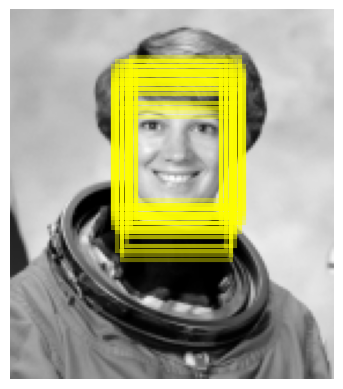

In [15]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i),
                               Nj, Ni,
                               edgecolor='yellow',
                              alpha=0.4, lw=3,
                              facecolor='none'))
plt.show()